<a href="https://colab.research.google.com/github/shiyxg/KAUST_log/blob/master/ErSe290_Salt_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salt Detection with U-net Lab 

See it here [lab](https://csim.kaust.edu.sa/files/ErSE394/LAB1/Chapter.CNN.Unet/U_Net_Lab.html)
---
![Unet Structure](https://csim.kaust.edu.sa/files/ErSE394/LAB1/Chapter.CNN.Unet/U_Net_structure_new.png)



In [ ]:
## Download Data

In [ ]:
! wget https://csim.kaust.edu.sa/files/ErSE394/LAB1/Chapter.CNN.Unet/U_Net_code.zip
! unzip U_Net_code.zip

## Load Keras Modules

---

In [ ]:
#Import Keras Modules
import os 
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline 

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import initializers
import tensorflow as tf

print("Keras version used: ", keras.__version__)
print("GPU imformation:", tf.test.gpu_device_name())
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

## Load Images and Labels

---

In [ ]:
# Set input width and height
im_width = 128
im_height = 128


# lload all the images in images folder
# The name of images are stored in ids
ids = next(os.walk("U_Net_code/images"))[2] 
# ids = next(os.walk("U_Net_code/images_full"))[2] 

print("No. of images = ", len(ids))

# Allocate the space for training and label
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    
# Load the all the images and labels, the labels are called as masks here
for n in range(len(ids)):
    # Load images
    # img_to_array: convert image to array
    img = load_img("./U_Net_code/images/"+ids[n], grayscale=True)
    # img = load_img("./U_Net_code/images_full/"+ids[n], grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("./U_Net_code/masks/"+ids[n], grayscale=True))
    # mask = load_img("./U_Net_code/masks_full/"+ids[n], grayscale=True)
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    
    # Normalization image
    X[n] = x_img.astype('float32')/255.0
    y[n] = mask.astype('float32')/65535


# Split all the images into training data and validation data
# test_size 0.2 means 20% valication set 80% training set
# random state: random seed
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


No. of images =  400


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
mask.max()

65535.0

## Visualize Images and Labels


---

1.0


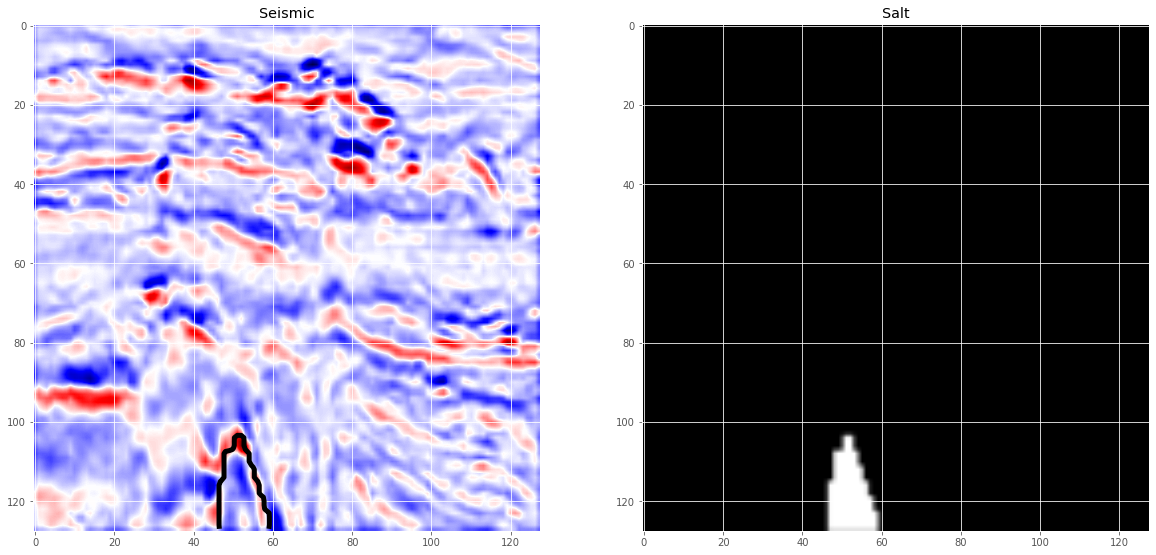

In [ ]:
# Visualize any random image and the mask in the training data
ix = random.randint(0, len(X_train))
# Plot seismic image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')

# If there is salt in the image, plot the boundary of salt as black line
has_mask = y_train[ix].max() > 0 # salt indicator
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

# Plot salt labels
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')
print(y_train.max())

## Setup U-Net Structure

---

In [ ]:
#define the convolution layer
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first convolution layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = initializers.he_normal(seed=1), padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second convolution layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = initializers.he_normal(seed=1), padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# define U_net architecture
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


## Training U-Net 

---

In [ ]:
# Set input layer size
input_img = Input((im_height, im_width, 1), name='img')
# Set the parameters for Unet
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
# Set optimizer, loss function. Set accuracy as metric
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

#Visualize the structure of Unet
model.summary()

# Set criterias for the inversion procedure
# Early Stopping: If the validation set loss function does not decrease in 10 iteration, then early stop.
# ReduceLROnPlateau: If the validation set loss function does not decrease in 5 iteration, then multiply learning rate with factor.
# ModelCheckpoint: save_weights_only=True--Save only the weight,
                  #save_best_only=True -- Only Save the best model with lowest validucation loss
                  #'model-tgs-salt.h5' -- file name
callbacks = [
    EarlyStopping(monitor='val_loss',patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

# Train the network
# Set the input
# batch_size--Size for each mini batch
# epochs--Epoch number
# X_train, y_train--Training data and labels
# X_valid, y_valid--Validation data and labels
results = model.fit(X_train, y_train, batch_size=32, epochs=30, callbacks=callbacks,\
validation_data=(X_valid, y_valid))    

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 128, 128, 16) 64          conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 128, 128, 16) 0           batch_normalization_36[0][0]     
_______________________________________________________________________________________

## Plot Learning Curve

---

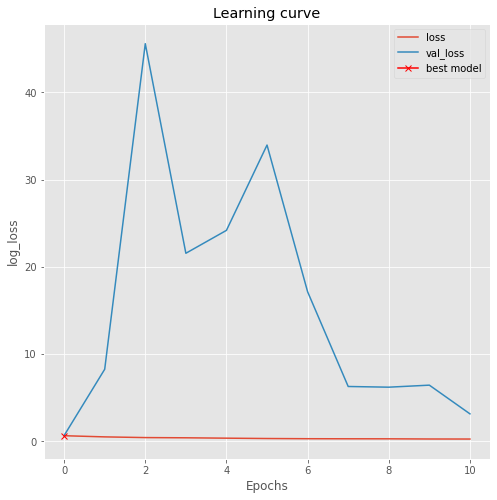

In [ ]:
# plot learning curve
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
# plot the location of the best model
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## Implement Model on Validation Set

---

In [ ]:
# load the best model
model.load_weights('model-tgs-salt.h5')

# Evaluate on validation set loss and accuracy
model.evaluate(X_valid, y_valid, verbose=1)

# Predict on training and validation set 
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

    

3/3 [==============================] - 0s 26ms/step


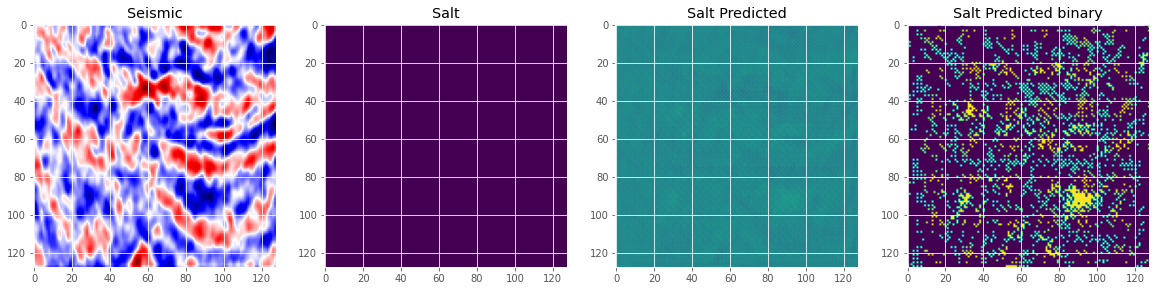

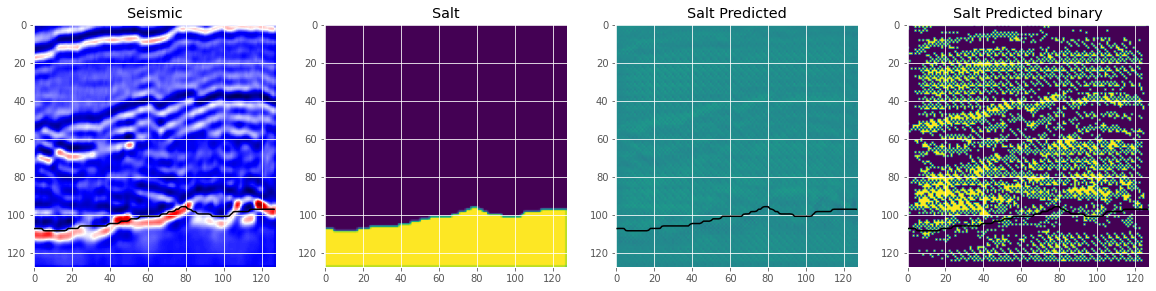

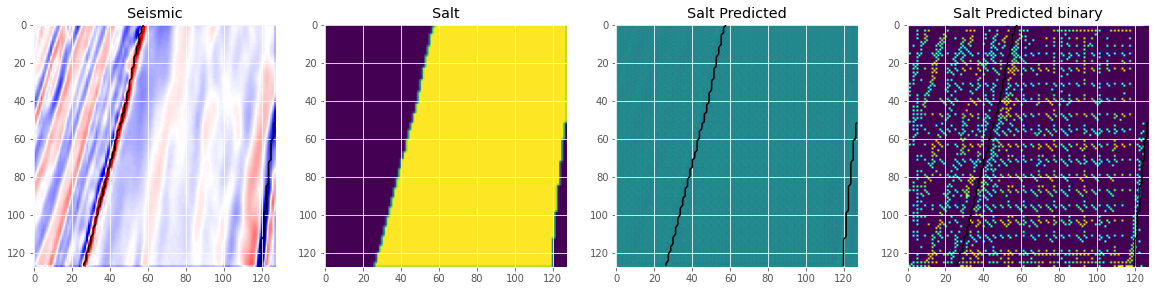

In [ ]:
# Plot predict results    

def plot_sample(X, y, preds, binary_preds, ix=None):

   """Function to plot the results"""
   # ix is None, then random select image to plot
   if ix is None:
      ix = random.randint(0, len(X))

   fig, ax = plt.subplots(1, 4, figsize=(20, 10))

   # plot input seismic image
   ax[0].imshow(X[ix, ..., 0], cmap='seismic')

   # If there is salt in the image, plot the boundary of salt as black line
   has_mask = y[ix].max() > 0
   if has_mask:
      ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
   ax[0].set_title('Seismic')

   # plot true salt labels
   ax[1].imshow(y[ix].squeeze())
   ax[1].set_title('Salt')

   # Plot predicted salt probability 
   ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
   if has_mask:
      ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
   ax[2].set_title('Salt Predicted')

   # Plot predicted salt Labels
   ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
   if has_mask:
      ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
   ax[3].set_title('Salt Predicted binary');

# Check if training data looks all right

plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14) 

plot_sample(X_train, y_train, preds_train, preds_train_t)

# Check if validation data looks all right

plot_sample(X_valid, y_valid, preds_val, preds_val_t)